# CSE473s Project

## Part-1 (XOR) [Section-2]
Implement our custom library, test it with [XOR] problem, validate it, and also implement the same exact problem using [TesnorFlow] or [Keras] then compare the results.

### Data initialization

In [33]:
import numpy as np
np.random.seed(42)

X = np.array([[-1, -1],[-1, 1],[1, -1],[1, 1]], dtype=np.float32)
y_true = np.array([[-1],[1],[1],[-1]], dtype=np.float32)

### Build netwrok with our custom library

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from lib import Sequential, Dense, Tanh, Sigmoid, ReLU, Softmax, MSELoss, SGDOptimizer as SGD

xor_model = Sequential([
    Dense(2, 4, 0.1), Tanh(), 
    Dense(4, 1, 0.1), Tanh()
])

opt = SGD(learning_rate=1.0)
loss_fn = MSELoss()

### Training loop

In [3]:
W1_init = xor_model.layers[0].params[0].copy()
b1_init = xor_model.layers[0].params[1].copy()
W2_init = xor_model.layers[2].params[0].copy()
b2_init = xor_model.layers[2].params[1].copy()

n_epochs = 5000

history = xor_model.fit(X, y_true, loss_fn, opt, epochs=n_epochs)

Epoch 0, Loss: 0.5055565845045331
Epoch 100, Loss: 0.005238414682047791
Epoch 200, Loss: 0.001456165233102437
Epoch 300, Loss: 0.0008220678957265347
Epoch 400, Loss: 0.0005675714746434494
Epoch 500, Loss: 0.0004315507010069525
Epoch 600, Loss: 0.0003472713340780499
Epoch 700, Loss: 0.0002900788978519814
Epoch 800, Loss: 0.00024879409951654625
Epoch 900, Loss: 0.0002176279432555727
Epoch 1000, Loss: 0.00019328805637913276
Epoch 1100, Loss: 0.00017376624002336197
Epoch 1200, Loss: 0.00015776917882511524
Epoch 1300, Loss: 0.00014442694970752612
Epoch 1400, Loss: 0.0001331332152452594
Epoch 1500, Loss: 0.00012345262116732008
Epoch 1600, Loss: 0.00011506461729137507
Epoch 1700, Loss: 0.000107728032309456
Epoch 1800, Loss: 0.00010125798531101837
Epoch 1900, Loss: 9.551040175621156e-05
Epoch 2000, Loss: 9.037136686373056e-05
Epoch 2100, Loss: 8.574964231874157e-05
Epoch 2200, Loss: 8.157130262727999e-05
Epoch 2300, Loss: 7.777582295582875e-05
Epoch 2400, Loss: 7.431318044341217e-05
Epoch 2500

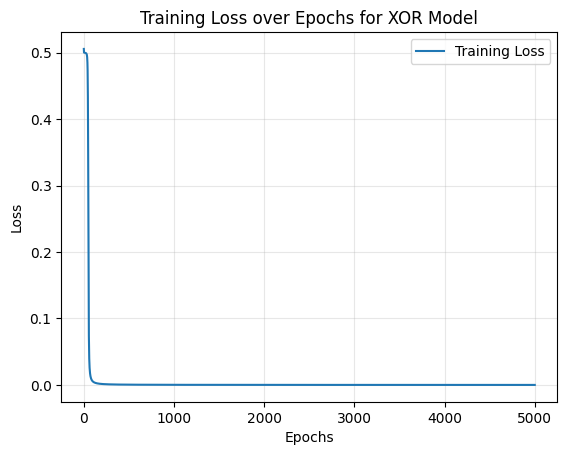

In [4]:
import matplotlib.pyplot as plt

plt.plot(history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs for XOR Model')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### Assert correctness

In [5]:
y_pred = xor_model.forward(X)

print("Raw preds:\n", y_pred)
print("Rounded:\n", np.int8(np.round(y_pred)))

y_test = xor_model.forward([-2.0, -2.0])
print("\nTest with random input (e.g.; [-2.0, -2.0]):", np.int8(np.round(y_test)))

Raw preds:
 [[-0.99080804]
 [ 0.99231939]
 [ 0.99275965]
 [-0.99118204]]
Rounded:
 [[-1]
 [ 1]
 [ 1]
 [-1]]

Test with random input (e.g.; [-2.0, -2.0]): [[-1]]


### Plotting
Plotting the classifier boundary layers

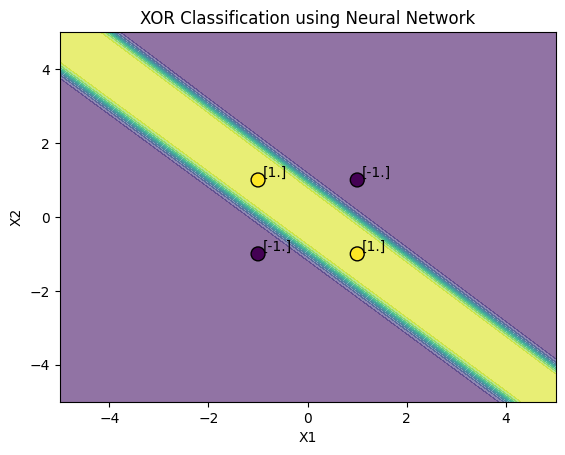

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of points for visualization
xx, yy = np.meshgrid(
    np.linspace(-5.0, 5.0, 200),
    np.linspace(-5.0, 5.0, 200)
)

grid_points = np.c_[xx.ravel(), yy.ravel()]  # shape (40000, 2)

# Predict on the grid
Z = xor_model.forward(grid_points)  # shape (40000, 1)
Z = Z.reshape(xx.shape)         # reshape to (200, 200)

# Plot classification regions
plt.contourf(xx, yy, Z, levels=np.linspace(-1, 1, 10).tolist(), alpha=0.6)

# Plot XOR data points
plt.scatter(X[:, 0], X[:, 1], s=100, c=y_true, edgecolors='k')
for i, txt in enumerate(y_true):
    plt.text(X[i, 0] + 0.1, X[i, 1] + 0.1, str(txt))

plt.title("XOR Classification using Neural Network")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

## Part-2
### Section-1 [Gradient-Checking]
Proving that our backpropagation is correct, by comparing its gradients with the gradients of numerical gradient descent.

#### Numerical gradient descent function

In [7]:
import numpy as np
from lib.layers import Dense

def compute_numerical_gradient(f, x, epsilon=1e-3):
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    
    while not it.finished:
        idx = it.multi_index
        original_value = x[idx]
        
        x[idx] = original_value + epsilon
        fx_plus = f(x)
        
        x[idx] = original_value - epsilon
        fx_minus = f(x)
        
        grad[idx] = (fx_plus - fx_minus) / (2 * epsilon)
        
        x[idx] = original_value
        it.iternext()
        
    return grad

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

#### Testing & comparing between our backprop and numerical gradient

In [8]:
input_size = 4
output_size = 2
N = 3  # batch size

X = np.random.randn(N, input_size)
dout = np.random.randn(N, output_size)

layer = Dense(input_size, output_size)

out = layer.forward(X)
dx_analytical = layer.backward(dout)
dW_analytical = layer.grads[0]
db_analytical = layer.grads[1]

def f_input(x):
    return np.sum(layer.forward(x) * dout)

dx_numerical = compute_numerical_gradient(f_input, X)

W_ref = layer.params[0] 

def f_weight(w):
    orig_W = layer.params[0]
    layer.params[0] = w
    result = np.sum(layer.forward(X) * dout)
    layer.params[0] = orig_W
    return result

dW_numerical = compute_numerical_gradient(f_weight, W_ref)

print("Gradient Check Results:")
print(f"dX Relative Error: {rel_error(dx_analytical, dx_numerical)}")
print(f"dW Relative Error: {rel_error(dW_analytical, dW_numerical)}")

if rel_error(dx_analytical, dx_numerical) < 1e-7:
    print("SUCCESS: Input gradients match.")
else:
    print("FAILURE: Input gradients do not match.")

Gradient Check Results:
dX Relative Error: 4.228005450877829e-13
dW Relative Error: 1.2882534077786793e-14
SUCCESS: Input gradients match.


### Section-3 [Autoencoder]

In [13]:
import numpy as np
import sys, os
sys.path.insert(0, os.path.abspath('..')) 

from lib import Sequential, Dense, ReLU, Sigmoid, MSELoss, SGDOptimizer as SGD
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False) 
X_mnist = mnist.data.astype(np.float32) / 255.0
y_mnist = mnist.target.astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X_mnist, y_mnist, test_size=0.2, random_state=42)

In [21]:
# Build autoencoder model network
autoencoder = Sequential([
    Dense(784, 128, 0.1), ReLU(),
    Dense(128, 64, 0.1), ReLU(),
    Dense(64, 32, 0.1), ReLU(),
    Dense(32, 64, 0.1), ReLU(),
    Dense(64, 128, 0.1), ReLU(),
    Dense(128, 784, 0.1), Sigmoid()
])

dense_idx = [0, 2, 4, 6, 8, 10]

ae_init_params = []
for i in dense_idx:
    W = autoencoder.layers[i].params[0].copy()
    b = autoencoder.layers[i].params[1].copy()
    ae_init_params.append((W, b))

print("Saved", len(ae_init_params), "Dense layers init params.")

Saved 6 Dense layers init params.


In [ ]:
import time
from tqdm import tqdm

optimizer = SGD(learning_rate=0.005)
loss_fn = MSELoss()

epochs = 10
batch_size = 64
history_ae = []
print("Starting training...")

t0 = time.perf_counter()
for epoch in range(epochs):
    
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train_shuffled = X_train[indices]
    
    epoch_loss = 0
    num_batches = 0

    for i in tqdm(range(0, X_train.shape[0], batch_size), 
                  desc=f"Epoch {epoch+1}/{epochs}", 
                  unit="batch"):
        
        X_batch = X_train_shuffled[i:i + batch_size]
        
        batch_loss = autoencoder.train_step(X_batch, X_batch, loss_fn, optimizer)
        epoch_loss += batch_loss
        num_batches += 1
        history_ae.append(epoch_loss / num_batches)
    
    avg_loss = epoch_loss / num_batches
    print(f"Average loss over batches: {avg_loss:.4f}")
t1 = time.perf_counter() - t0
print(f"Training completed in {t1:.2f} seconds.")

Starting training...


Epoch 1/10: 100%|██████████| 875/875 [00:04<00:00, 211.98batch/s]


Average loss over batches: 0.0057


Epoch 2/10: 100%|██████████| 875/875 [00:04<00:00, 207.40batch/s]


Average loss over batches: 0.0057


Epoch 3/10: 100%|██████████| 875/875 [00:03<00:00, 225.65batch/s]


Average loss over batches: 0.0057


Epoch 4/10: 100%|██████████| 875/875 [00:03<00:00, 241.92batch/s]


Average loss over batches: 0.0056


Epoch 5/10: 100%|██████████| 875/875 [00:03<00:00, 240.97batch/s]


Average loss over batches: 0.0056


Epoch 6/10: 100%|██████████| 875/875 [00:03<00:00, 238.33batch/s]


Average loss over batches: 0.0056


Epoch 7/10: 100%|██████████| 875/875 [00:03<00:00, 228.37batch/s]


Average loss over batches: 0.0056


Epoch 8/10: 100%|██████████| 875/875 [00:03<00:00, 239.96batch/s]


Average loss over batches: 0.0055


Epoch 9/10: 100%|██████████| 875/875 [00:03<00:00, 237.38batch/s]


Average loss over batches: 0.0055


Epoch 10/10: 100%|██████████| 875/875 [00:03<00:00, 231.83batch/s]

Average loss over batches: 0.0055


#### Loss curve plotting

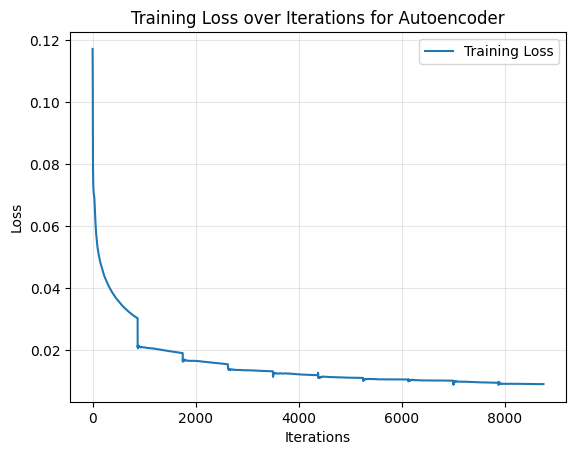

In [23]:
plt.plot(history_ae, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations for Autoencoder')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### Visulaization of original vs. reconstructed test images

reconstructing...


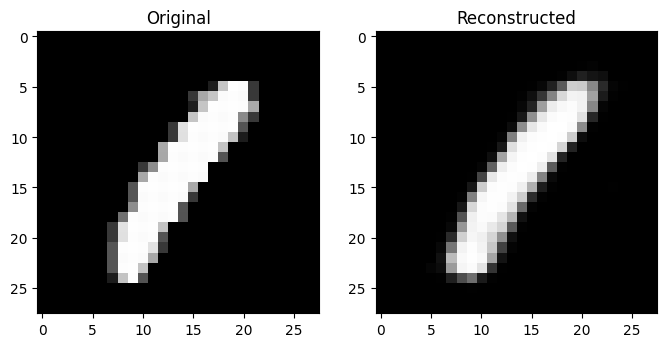

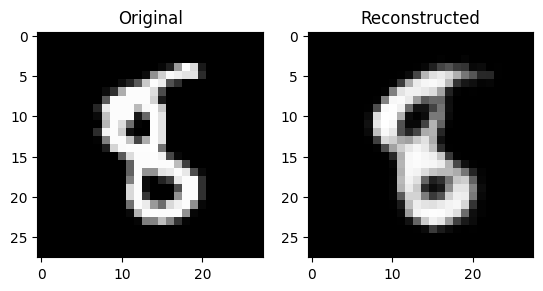

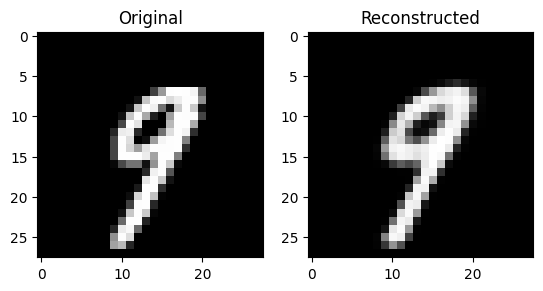

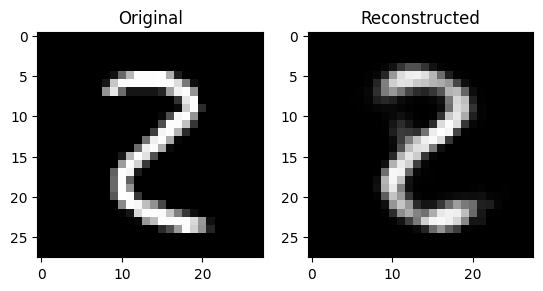

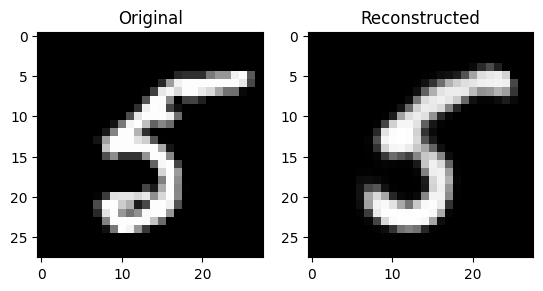

In [37]:
print("reconstructing...")
X_test_reconstructed = autoencoder.forward(X_test) # Predict on a subset to save memory if needed

# Visualize
n_samples = 5
plt.figure(figsize=(8, 4))
for i in range(n_samples):
    n = np.random.randint(0, X_test.shape[0]-1)
    # Original
    plt.subplot(1, 2, 1)
    plt.imshow((X_test[n].reshape(28, 28)*255).astype(np.uint8), cmap='gray')
    plt.title(f"Original")

    # Reconstructed
    plt.subplot(1, 2, 2)
    plt.imshow((X_test_reconstructed[n].reshape(28, 28)*255).astype(np.uint8), cmap='gray')
    plt.title(f"Reconstructed")
    plt.show()

#### Pre-trained encoder

Separate the pre-trained encoder, and use it as a feature extractor of the MNIST images dataset.
[Z]

In [38]:
from lib import Sequential, Dense, ReLU, Sigmoid, MSELoss, SGDOptimizer as SGD  
encoder = Sequential(autoencoder.layers[:6])

def extract_features(model, X, bs=512):
    out = []
    for i in range(0, X.shape[0], bs):
        out.append(model.forward(X[i:i+bs]))
    return np.vstack(out)

Z_train = extract_features(encoder, X_train)
Z_test  = extract_features(encoder, X_test)

### Section-4 [SVM classifier]

Train SVM classifier on the feature extracted using our custom pre-trained encoder.

Accuracy: 0.9064285714285715
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1343
           1       0.96      0.98      0.97      1600
           2       0.90      0.89      0.89      1380
           3       0.88      0.89      0.88      1433
           4       0.90      0.91      0.91      1295
           5       0.88      0.84      0.86      1273
           6       0.93      0.95      0.94      1396
           7       0.91      0.91      0.91      1503
           8       0.88      0.85      0.87      1357
           9       0.88      0.87      0.87      1420

    accuracy                           0.91     14000
   macro avg       0.91      0.90      0.90     14000
weighted avg       0.91      0.91      0.91     14000



<Figure size 640x480 with 0 Axes>

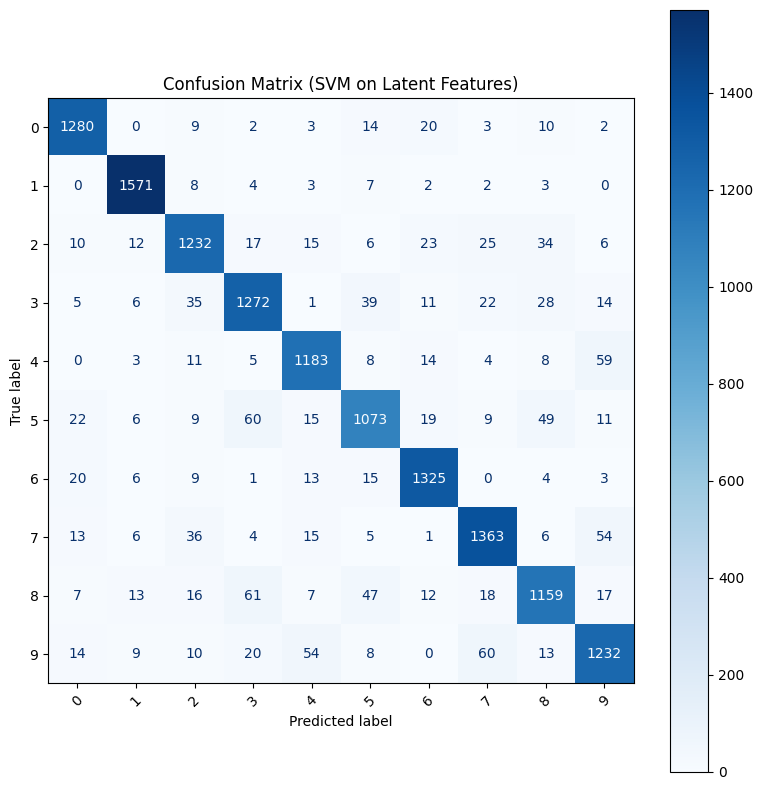

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

svm = make_pipeline(StandardScaler(), LinearSVC(C=1.0))
svm.fit(Z_train, y_train)

y_pred = svm.predict(Z_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=svm.classes_)
plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
cm.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Confusion Matrix (SVM on Latent Features)")
plt.tight_layout()
plt.show()

#### Classifier results

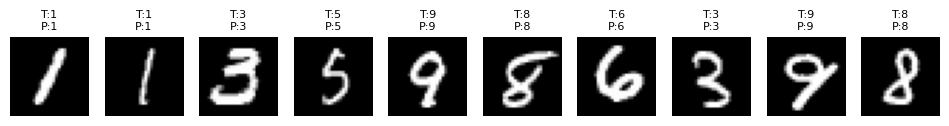

In [42]:
def show_random(n=12):
    idxs = np.random.choice(len(X_test), size=n, replace=False)
    plt.figure(figsize=(12,3))
    for j, idx in enumerate(idxs):
        x = X_test[idx]
        true = y_test[idx]
        pred = svm.predict(Z_test[idx:idx+1])[0]

        plt.subplot(1, n, j+1)
        plt.imshow((x.reshape(28,28)*255).astype(np.uint8), cmap="gray")
        plt.title(f"T:{true}\nP:{pred}", fontsize=8)
        plt.axis("off")
    plt.show()

show_random(10)

### Section-5 [TensorFlow/Keras]
The TensorFlow/Keras implementations and comparisons.

In [43]:
import time
import numpy as np
import tensorflow as tf


def half_mse(y_true, y_pred):
    return 0.5 * tf.reduce_mean(tf.square(y_true - y_pred))

xor_tf_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Activation("tanh"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation("tanh"),
])
xor_tf_model.summary()

_ = xor_tf_model(np.zeros((1, 2), dtype=np.float32))
dense_layers = [l for l in xor_tf_model.layers if isinstance(l, tf.keras.layers.Dense)]
assert len(dense_layers) == 2
W1 = W1_init.astype(np.float32)                  # (2,4)
b1 = b1_init.astype(np.float32).reshape(-1)      # (1,4)->(4,)
W2 = W2_init.astype(np.float32)                  # (4,1)
b2 = b2_init.astype(np.float32).reshape(-1)      # (1,1)->(1,)

# Sanity checks
assert W1.shape == (2, 4), f"W1 shape wrong: {W1.shape}"
assert b1.shape == (4,),   f"b1 shape wrong: {b1.shape}"
assert W2.shape == (4, 1), f"W2 shape wrong: {W2.shape}"
assert b2.shape == (1,),   f"b2 shape wrong: {b2.shape}"

# Set initial weights
dense_layers[0].set_weights([W1, b1])
dense_layers[1].set_weights([W2, b2])

lr = 1.0
xor_tf_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
    loss=half_mse
)

t0 = time.perf_counter()
hist = xor_tf_model.fit(X, y_true, epochs=n_epochs, verbose=0)
t_train = time.perf_counter() - t0

y_pred = xor_tf_model.predict(X, verbose=0)

print("Train time (s):", t_train)
print("Final loss:", hist.history["loss"][-1])
print("Raw preds:\n", np.round(y_pred, 3))

y_pred_sign = np.where(y_pred >= 0, 1, -1).astype(np.int8)

print("True:\n", y_true.ravel().astype(np.int8))
print("Pred sign:\n", y_pred_sign.ravel())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

2025-12-16 04:57:48.058729: I external/local_xla/xla/service/service.cc:163] XLA service 0x7cd7e8004c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-16 04:57:48.058768: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-12-16 04:57:48.104308: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-16 04:57:48.203765: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
I0000 00:00:1765853868.422722  745677 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Train time (s): 170.08040391199938
Final loss: 3.4214885090477765e-05
Raw preds:
 [[-0.991]
 [ 0.992]
 [ 0.993]
 [-0.991]]
True:
 [-1  1  1 -1]
Pred sign:
 [-1  1  1 -1]


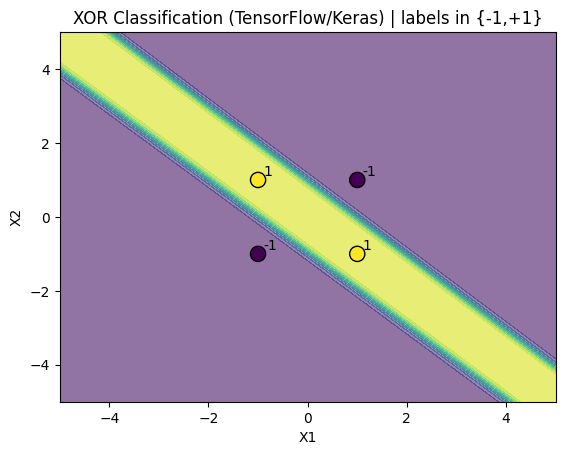

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Grid
xx, yy = np.meshgrid(
    np.linspace(-5.0, 5.0, 200),
    np.linspace(-5.0, 5.0, 200)
)
grid_points = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)

# Predict on grid
Z = xor_tf_model.predict(grid_points, verbose=0).reshape(xx.shape)  # values in [-1,1]

plt.figure()
plt.contourf(xx, yy, Z, levels=np.linspace(-1, 1, 10).tolist(), alpha=0.6)

plt.scatter(X[:, 0], X[:, 1], s=120, c=y_true.ravel(), edgecolors="k")

for i, txt in enumerate(y_true.ravel()):
    plt.text(X[i, 0] + 0.1, X[i, 1] + 0.1, str(int(txt)))

plt.title("XOR Classification (TensorFlow/Keras) | labels in {-1,+1}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [45]:
inp = tf.keras.Input(shape=(784,))
x = tf.keras.layers.Dense(128)(inp); x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dense(64)(x);    x = tf.keras.layers.ReLU()(x)
z = tf.keras.layers.Dense(32)(x);    z = tf.keras.layers.ReLU()(z)        # latent (after ReLU)

x = tf.keras.layers.Dense(64)(z);    x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dense(128)(x);   x = tf.keras.layers.ReLU()(x)
out = tf.keras.layers.Dense(784)(x); out = tf.keras.layers.Activation("sigmoid")(out)

autoencoder_tf = tf.keras.Model(inp, out, name="autoencoder_tf")
encoder_tf     = tf.keras.Model(inp, z,   name="encoder_tf")

# build variables once (required before set_weights)
_ = autoencoder_tf(np.zeros((1, 784), dtype=np.float32))

try:
    tf_dense_layers = [l for l in autoencoder_tf.layers if isinstance(l, tf.keras.layers.Dense)]
    assert len(tf_dense_layers) == 6

    if "ae_init_params" in globals() and ae_init_params is not None:
        assert len(ae_init_params) == 6, f"ae_init_params must have 6 items, got {len(ae_init_params)}"

        for dl, (W, b) in zip(tf_dense_layers, ae_init_params):
            dl.set_weights([W.astype(np.float32), b.astype(np.float32).reshape(-1)])  # (1,out)->(out,)
        print("Set TF initial weights from ae_init_params.")
    else:
        print(" ae_init_params not found -> TF uses its own random init.")
except Exception as e:
    print("Skipped set_weights due to:", e)

autoencoder_tf.summary()

lr = 0.8
epochs = 30
batch_size = 64

autoencoder_tf.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
    loss=half_mse
)

t0 = time.perf_counter()
hist = autoencoder_tf.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2
)
t_train = time.perf_counter() - t0

test_loss = autoencoder_tf.evaluate(X_test, X_test, verbose=0)

Set TF initial weights from ae_init_params.


Model: "autoencoder_tf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 784)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,384 (868.69 KB)

 Trainable params: 222,384 (868.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


2025-12-16 05:02:05.739968: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-16 05:02:05.740027: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-16 05:02:05.740107: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-16 05:02:05.740137: I external/l

875/875 - 18s - 20ms/step - loss: 0.0557 - val_loss: 0.0356
Epoch 2/30
875/875 - 1s - 1ms/step - loss: 0.0344 - val_loss: 0.0331
Epoch 3/30
875/875 - 1s - 1ms/step - loss: 0.0326 - val_loss: 0.0318
Epoch 4/30
875/875 - 1s - 1ms/step - loss: 0.0313 - val_loss: 0.0304
Epoch 5/30
875/875 - 1s - 1ms/step - loss: 0.0298 - val_loss: 0.0289
Epoch 6/30
875/875 - 1s - 1ms/step - loss: 0.0281 - val_loss: 0.0271
Epoch 7/30
875/875 - 1s - 1ms/step - loss: 0.0264 - val_loss: 0.0257
Epoch 8/30
875/875 - 1s - 1ms/step - loss: 0.0251 - val_loss: 0.0244
Epoch 9/30
875/875 - 1s - 1ms/step - loss: 0.0239 - val_loss: 0.0231
Epoch 10/30
875/875 - 1s - 1ms/step - loss: 0.0226 - val_loss: 0.0219
Epoch 11/30
875/875 - 1s - 1ms/step - loss: 0.0214 - val_loss: 0.0208
Epoch 12/30
875/875 - 1s - 1ms/step - loss: 0.0204 - val_loss: 0.0199
Epoch 13/30
875/875 - 1s - 1ms/step - loss: 0.0196 - val_loss: 0.0192
Epoch 14/30
875/875 - 1s - 1ms/step - loss: 0.0189 - val_loss: 0.0185
Epoch 15/30
875/875 - 1s - 1ms/step - 

2025-12-16 05:02:55.890302: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-16 05:02:57.147033: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 100 bytes spill stores, 100 bytes spill loads



In [46]:
print("\nAE train time (s):", t_train)
print("AE test reconstruction loss:", test_loss)


AE train time (s): 50.99489460499899
AE test reconstruction loss: 0.013000349514186382


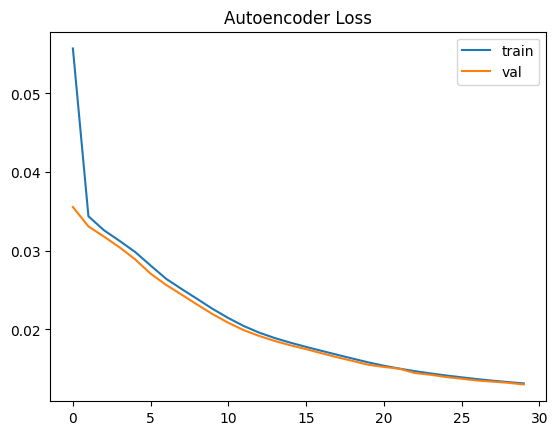

In [47]:
# ---------- 6) Plot loss ----------
plt.figure()
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.legend()
plt.title("Autoencoder Loss")
plt.show()

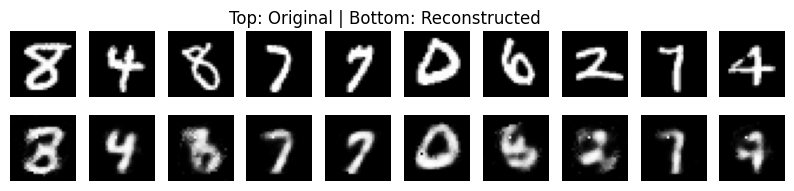

In [48]:
# ---------- 7) Visualize reconstructions ----------
n = 10
recon = autoencoder_tf.predict(X_test[:n], verbose=0)

plt.figure(figsize=(10, 2))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28,28), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
    plt.subplot(2, n, n+i+1)
    plt.imshow(recon[i].reshape(28,28), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.suptitle("Top: Original | Bottom: Reconstructed")
plt.show()

2025-12-16 05:04:09.561714: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 4 bytes spill stores, 4 bytes spill loads

2025-12-16 05:04:10.200463: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 8 bytes spill stores, 8 bytes spill loads

2025-12-16 05:04:12.806800: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 4 bytes spill stores, 4 bytes spill loads

2025-12-16 05:04:13.879136: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 4 bytes spill stores, 4 bytes spill loads



Z_train: (56000, 32) Z_test: (14000, 32)
SVM accuracy: 0.8523571428571428
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1343
           1       0.92      0.97      0.95      1600
           2       0.82      0.82      0.82      1380
           3       0.80      0.83      0.81      1433
           4       0.82      0.83      0.83      1295
           5       0.79      0.75      0.77      1273
           6       0.89      0.90      0.90      1396
           7       0.87      0.89      0.88      1503
           8       0.85      0.79      0.82      1357
           9       0.80      0.75      0.78      1420

    accuracy                           0.85     14000
   macro avg       0.85      0.85      0.85     14000
weighted avg       0.85      0.85      0.85     14000



<Figure size 640x480 with 0 Axes>

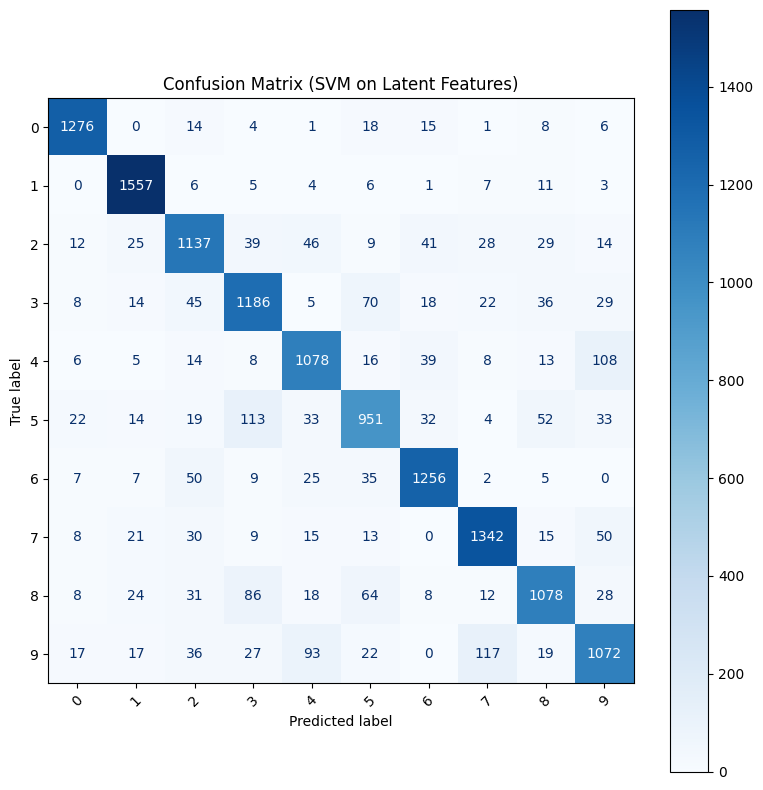

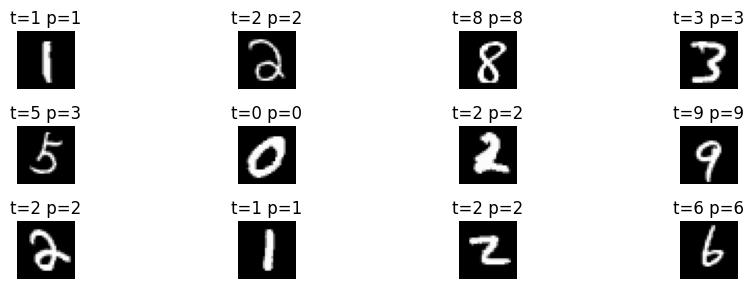

In [49]:
Z_train = encoder_tf.predict(X_train, batch_size=1024, verbose=0)
Z_test  = encoder_tf.predict(X_test,  batch_size=1024, verbose=0)

print("Z_train:", Z_train.shape, "Z_test:", Z_test.shape)   # should be (N, 32)

svm = make_pipeline(
    StandardScaler(),
    LinearSVC(C=1.0, dual="auto", max_iter=5000)
)

svm.fit(Z_train, y_train)

y_pred = svm.predict(Z_test)

print("SVM accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=svm.classes_)
plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
cm.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Confusion Matrix (SVM on Latent Features)")
plt.tight_layout()
plt.show()

idx = np.random.choice(len(X_test), 12, replace=False)
plt.figure(figsize=(10, 3))
for k, i in enumerate(idx):
    plt.subplot(3, 4, k+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray", vmin=0, vmax=1)
    plt.title(f"t={y_test[i]} p={y_pred[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()